# Dune Glider optimization code

This is the main optimization code for Dune Glider. 

Lets use `aerosandbox` to extract aerodynamic coefficients from an aircraft model.

In [15]:
%matplotlib widget
import aerosandbox as asb
import aerosandbox.numpy as np
from pathlib import Path
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p
import scipy.optimize
from dune_plot_tools import *
from aircraft_model import WingSection
from dune_opt import OptScore



## Aircraft definition and simulation

We define an aircraft based on 3 main parameters:
- Wing root chord
- Wing tip chord
- Wing sweep

This version of the aircraft has only one wing section. The method used to get the aerodynamic coefficients is the Aerobuildup method.

Considerations:

- We use a take-off speed of $8 m/s$
- The max wing span is $3 m$

In [16]:
def simulate_aircraft(wing_root_chord = 1, 
                      wing_tip_chord = 1,
                      wing_sweep = np.radians(40),
                      should_plot=False):
    
    wing_max_span = 3   
    wing_root_pnt = np.array([0, 0, 0])
    wing_sec1 = WingSection( span_tip=(wing_max_span)/2,
                            sweep = wing_sweep,
                            chord_tip = wing_tip_chord,
                            airfoil = asb.Airfoil("l1003"),
                            init_point = wing_root_pnt,
                            init_chord = wing_root_chord)

    def get_plane(xyz_ref=np.array([0, 0, 0])):
        return asb.Airplane(
            name="Dune Glider",
            xyz_ref=xyz_ref,  # CG location
            wings=[
                asb.Wing(
                    name="Main Wing",
                    symmetric=True,  # Should this wing be mirrored across the XZ plane?
                    xsecs=[  # The wing's cross ("X") sections
                        asb.WingXSec(  # Root
                            xyz_le = wing_root_pnt,  # Coordinates of the XSec's leading edge, relative to the wing's leading edge.
                            chord = wing_root_chord,
                            twist = 0.0,  # degrees
                            airfoil = asb.Airfoil("l1003")
                        ),
                        asb.WingXSec(
                            xyz_le = wing_sec1.get_wing_tip_offset(),
                            chord = wing_sec1.chord_tip,
                            twist = 0,
                            airfoil= wing_sec1.airfoil
                        ),
                    ]
                )
            ]
        )

    # Get the aerodynamic center of the aircraft and add the CG one meter below it
    ac = get_plane().aerodynamic_center() + np.array([0, 0, -1 ])

    # Get the airplane with the corrected CG
    airplane = get_plane(ac)

    # Plot airplane
    if should_plot:
        airplane.draw_three_view()

    # AEROBUILDUP METHOD
    op_point = asb.OperatingPoint(
        atmosphere=asb.Atmosphere(altitude=0),
        velocity = 8,  # m/s
    )
    xyz_ref = ac


    ab_op_point = op_point.copy()
    ab_op_point.alpha = np.linspace(-12, 25, 50)
    aerobuildup_aero = asb.AeroBuildup(
        airplane=airplane,
        op_point=ab_op_point,
        xyz_ref=xyz_ref
    ).run()

    aerobuildup_aero["alpha"] = ab_op_point.alpha
    aerobuildup_aero["CL/CD"] = np.divide(aerobuildup_aero["CL"], aerobuildup_aero["CD"])
    
    # PLOT:
    if should_plot:
        plot_polars(aerobuildup_aero, "AeroBuildup method")

    return aerobuildup_aero, airplane

## Cost function

In this version of Dune Glider we will evaluate the creation of a flying wing to optimize both the **Lift coefficient** ($C_L$) and the **relation between the Lift and Drag** ($C_L / C_D$).

### Why?

The speed of a person practicing sandboard in the dunes are not that high. By video analysis we estimated that a person can achieve around $8 m/s$ during a dune descent. Therefore, it is necessary to make lift as one of the priorities. However, ignoring drag in the optimization will only result in wings with both high lift and drag. The problem is that with high drag it will avoid reaching the desired speed when sandboarding. 

### Stability and control for a flying wing

Modeling a flying wing with no control surface we need to fly with a specific angle of attack. For this project we use the $\alpha$ with the biggest $C_L/C_D$ value.

\begin{equation}
    \alpha_{op} = max(C_L/C_D)
\end{equation}

When $\alpha = \alpha_{op}$ the aircraft has the best relation between lift and drag and this is defined as our operating point. To make the aircraft to stabilize in $\alpha_{op}$ we need to follow certain conditions:

\begin{align*}
C_m \leq 0,\quad\text{when $\alpha \geq \alpha_{op}$.}\\
C_m \geq 0,\quad\text{when $\alpha \leq \alpha_{op}$.}
\end{align*}

In a practical sense this means that the aircraft will naturally try to stabilize its angle of attack to our desired operating point. This leads us to another condition.

\begin{align*}
C_m \approx 0,\quad\text{when $\alpha = \alpha_{op}$.}
\end{align*}

Which means the moment in the operating point is zero and the aircraft will not try to rotate in any direction. That is what we want.

In [17]:
def function_to_optimize(x):
    aero, _ = simulate_aircraft(wing_root_chord = x[0],
                                wing_tip_chord = x[1],
                                wing_sweep = x[2])
    
    # Calculate optimization function

    # We maximize the CL/CD
    max_clcd = np.max(aero['CL/CD'])
    max_clcd_alpha = np.argmax(aero['CL/CD'])

    # CM should be below zero in all alpha above zero. Same in the opposite direction 
    # We can create a "score" using a sigmoid function
    npoints = len(aero['Cm'])
    sum_score_cm = 0
    for i in range(npoints):
        if aero['alpha'][i] >= max_clcd_alpha:
            y = 1 / (1 + np.exp((aero['Cm'][i]-0.05)*100))
            sum_score_cm += y
            # print(aero['alpha'][i],", ", aero['Cm'][i], ", ", y)
        else:
            y = 1 / (1 + np.exp(-(aero['Cm'][i]+0.05)*100))
            sum_score_cm += y
            # print(aero['alpha'][i],", ", aero['Cm'][i], ", ", y)

    # If the score is 1, it is perfect
    normalized_avg_cm_score = sum_score_cm/npoints
    normalized_avg_cm_score = 1

    cl_alpha_in_max_clcd = aero['CL'][max_clcd_alpha]
    cm_alpha_in_max_clcd = aero['Cm'][max_clcd_alpha]

    # We expect the Cm around the max CL/CD point is near zero as possible, so we use a d(tanh)/dx function
    score_cm_alpha_max_clcd = 1-np.power(cm_alpha_in_max_clcd*(1/0.2),2)

    score = max_clcd*normalized_avg_cm_score*cl_alpha_in_max_clcd*score_cm_alpha_max_clcd
    return -(score)

## Callback function

We can define a callback to store the local minimum for each basinhopping local minimum. We can also store each iteration's aircraft.

In [18]:
optscore = OptScore()
# Callback function to store information about the local minimum
def local_min_callback(x, f, accepted):
    if accepted:
        aero, airplane = simulate_aircraft(wing_root_chord = x[0],
                                           wing_tip_chord = x[1],
                                           wing_sweep = x[2])
        optscore.add_local_min(x, f, aero, airplane)

def all_steps_callback(x):
    aero, airplane = simulate_aircraft(wing_root_chord = x[0],
                                       wing_tip_chord = x[1],
                                       wing_sweep = x[2])
    optscore.add_step_to_eval_list(x, function_to_optimize(x), aero, airplane)

## Run optimization

For this optimization we are using the [basinhopping](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html) algorithm to find the global minimum of the function. This method will use another method [L-BFGS-B](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html) to find the local minimum. We set a number of max iteration of 20.

The `L-BFGS-B` allows the use of bounderies for the variables. We limit the root and tip chord to have a value between $5 cm$ and $2 m$ and the sweep angle between $0º$ and $45º$

In [19]:
#               wing_root_chord   wing_tip_chord   wing_sweep
init_values  = [1,                1,                np.radians(0)]
bound_values = [(0.05, 2),        (0.05, 2),       (np.radians(0), np.radians(45))]

minimizer_kwargs = {"method": "L-BFGS-B", "bounds":bound_values, 'options':{"disp": True}}
# minimizer_kwargs = {"method": "L-BFGS-B", "bounds":bound_values, "callback":all_steps_callback, 'options':{"disp": True}}
xopt = scipy.optimize.basinhopping(function_to_optimize, x0=init_values, niter=100, minimizer_kwargs=minimizer_kwargs, callback=local_min_callback)

aero, airplane = simulate_aircraft(wing_root_chord = xopt.x[0],
                                   wing_tip_chord = xopt.x[1],
                                   wing_sweep = xopt.x[2])
optscore.set_global_min(xopt.x, xopt.fun, aero, airplane)

## Plotting the optimizer population

The following plot shows the score in color. The axis represents the CL and CL/CD of each invidious. 

Click in the point to plot the aircraft in 3D. 

Clicked on Point 13
88


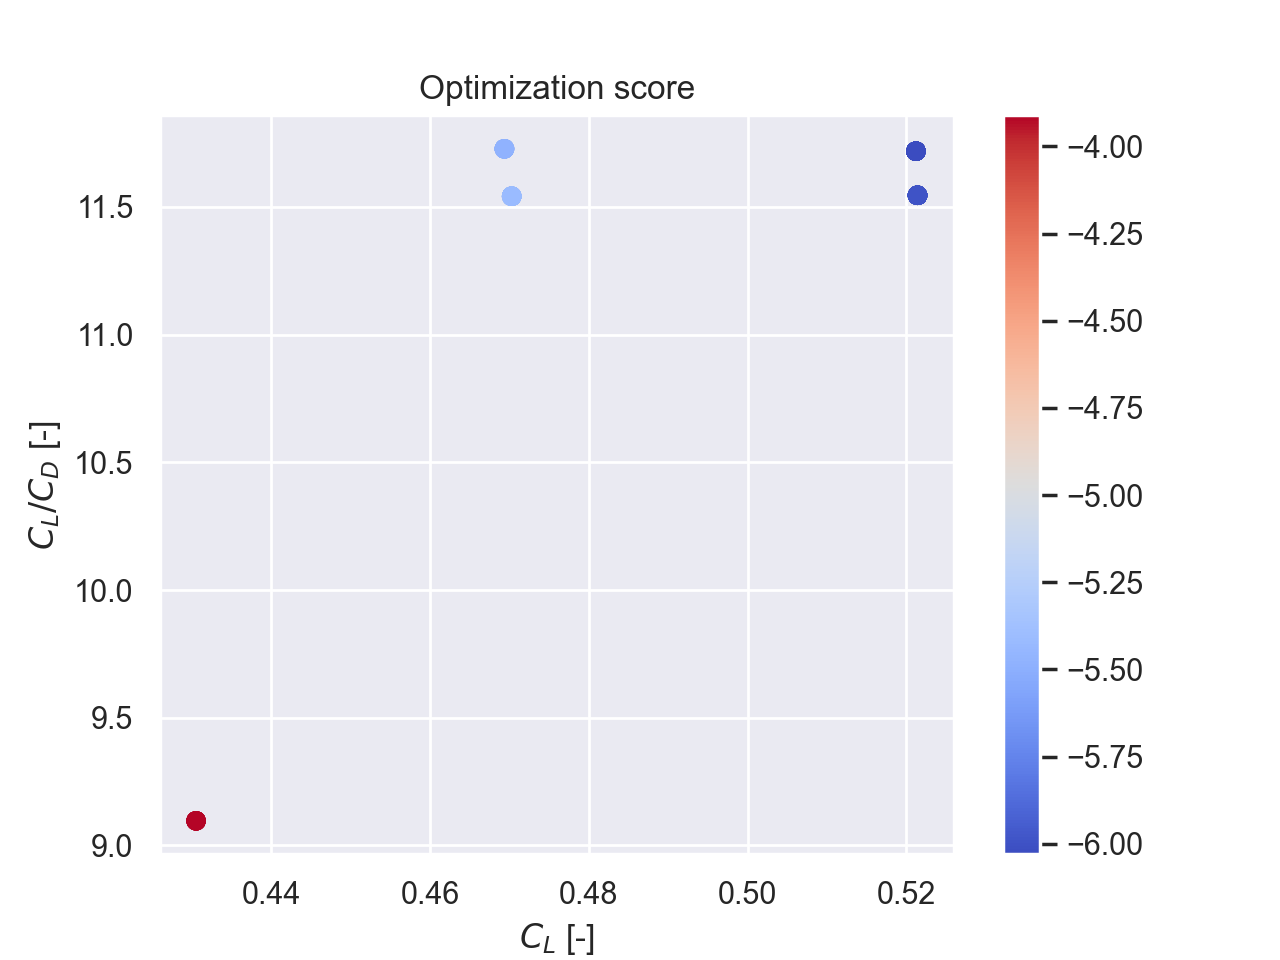

wing_root_chord: 1.2848173009851045
wing_tip_chord: 0.05
wing_sweep: 17.05126367509853


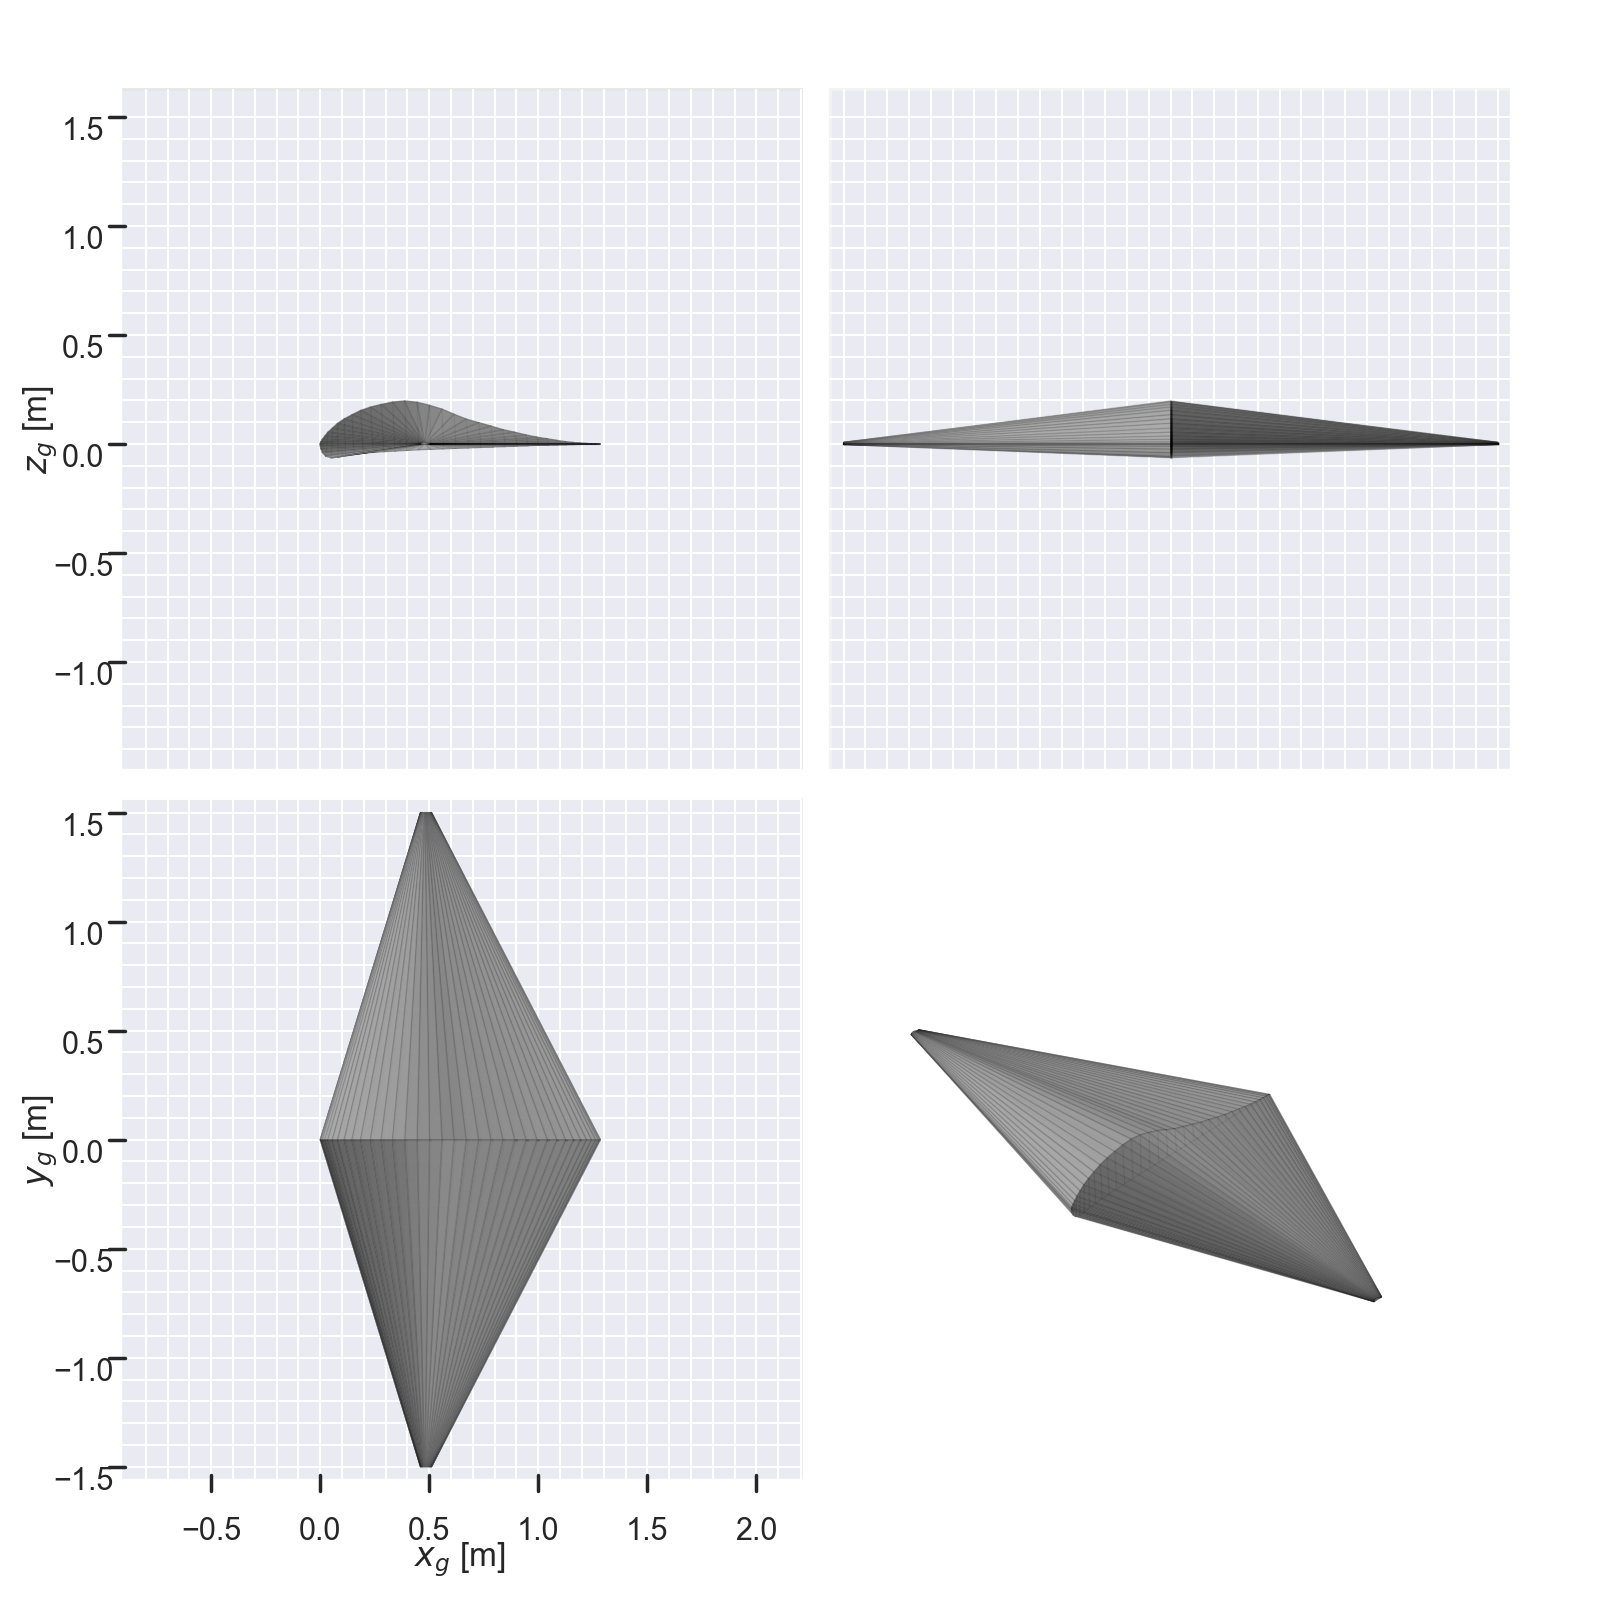

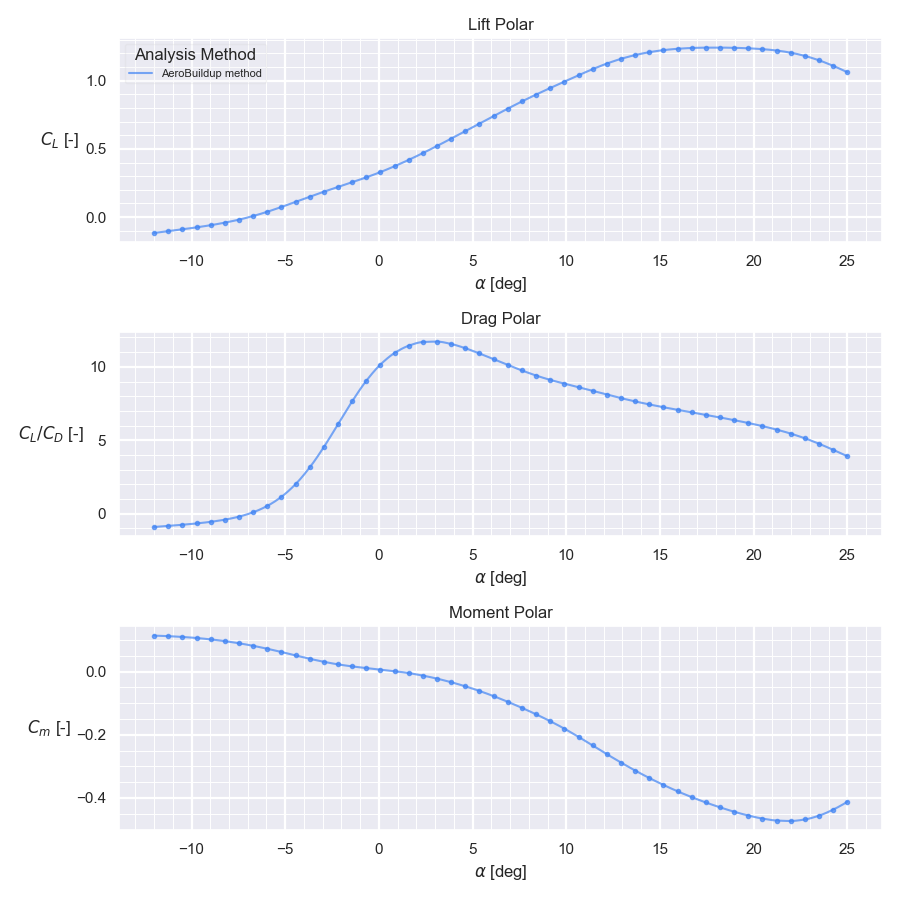

In [20]:
plot_opt_score(optscore)

In [23]:
print(xopt.message)
print(xopt.x)
print(xopt.fun)
print(f"wing_root_chord: {xopt.x[0]}")
print(f"wing_tip_chord: {xopt.x[1]}")
print(f"wing_sweep: {xopt.x[2]*180/np.pi}")


['requested number of basinhopping iterations completed successfully']
[1.28481828 0.05       0.29760086]
-6.030721195042438
wing_root_chord: 1.2848182843341136
wing_tip_chord: 0.05
wing_sweep: 17.05127343701838


In [25]:


op_point = asb.OperatingPoint(
    atmosphere=asb.Atmosphere(altitude=0),
    velocity=8,  # m/s
    alpha=np.radians(2.5)
)

vlm = asb.VortexLatticeMethod(
    airplane=airplane,
    op_point=op_point,
    spanwise_resolution=1,
    chordwise_resolution=30,
)

aero = vlm.run()

vlm.draw(backend='plotly')
print("")
